In [2]:
# 1. Install libraries
!pip install -q transformers datasets scikit-learn

In [1]:
# 2. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 3. Import libraries
import os
import pandas as pd
import re
import nltk
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, hamming_loss
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, BertForSequenceClassification, DataCollatorWithPadding, get_scheduler
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import time

In [4]:
# 4. Define paths
earphones_path = '/content/drive/MyDrive/kaggle_datasets/amazon_review/Amazon Earphones Reviews'
products_path = '/content/drive/MyDrive/kaggle_datasets/amazon_review/Amazon Product Reviews'

# Verify paths
print("Amazon-Earphones-Reviews:", os.listdir(earphones_path))
print("Amazon-Product-Reviews:", os.listdir(products_path))

Amazon-Earphones-Reviews: ['AllProductReviews.csv', 'ProductInfo.csv']
Amazon-Product-Reviews: ['Amazon-Product-Reviews - Amazon Product Review (1).csv']


In [5]:
# 5. Load CSVs
df_earphones_reviews = pd.read_csv(earphones_path + '/AllProductReviews.csv')
df_earphones_info = pd.read_csv(earphones_path + '/ProductInfo.csv')
df_products = pd.read_csv(products_path + '/Amazon-Product-Reviews - Amazon Product Review (1).csv')

# Preview the data
print("Earphones Reviews:")
print(df_earphones_reviews.head(), '\n')

print("Earphones Product Info:")
print(df_earphones_info.head(), '\n')

print("Amazon Product Reviews:")
print(df_products.head())


Earphones Reviews:
                                        ReviewTitle  \
0             Honest review of an edm music lover\n   
1             Unreliable earphones with high cost\n   
2                        Really good and durable.\n   
3                 stopped working in just 14 days\n   
4  Just Awesome Wireless Headphone under 1000...😉\n   

                                          ReviewBody  ReviewStar  \
0  No doubt it has a great bass and to a great ex...           3   
1  This  earphones are unreliable, i bought it be...           1   
2  i bought itfor 999,I purchased it second time,...           4   
3  Its sound quality is adorable. overall it was ...           1   
4  Its Awesome... Good sound quality & 8-9 hrs ba...           5   

            Product  
0  boAt Rockerz 255  
1  boAt Rockerz 255  
2  boAt Rockerz 255  
3  boAt Rockerz 255  
4  boAt Rockerz 255   

Earphones Product Info:
    MRP  Price                                    ProductFullName  \
0  2990   1399

In [6]:
# 5. Text cleaning function


# NLTK setup
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = BeautifulSoup(str(text), "html.parser").get_text()  # remove HTML
    text = re.sub(r"http\S+|www.\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove non-letters
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()  # normalize spaces
    return text

def preprocess_text(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [7]:
# 7. Preprocess datasets

# --- Preprocess Earphones Reviews ---
earphones = df_earphones_reviews[['ReviewBody', 'ReviewStar']].dropna()
earphones = earphones.rename(columns={'ReviewBody': 'review', 'ReviewStar': 'rating'})
earphones['cleaned_review'] = earphones['review'].apply(preprocess_text)
earphones['source'] = 'earphones'

# --- Preprocess Amazon Product Reviews ---
products = df_products[['review_body', 'star_rating']].dropna()
products = products.rename(columns={'review_body': 'review', 'star_rating': 'rating'})
products['cleaned_review'] = products['review'].apply(preprocess_text)
products['source'] = 'products'

# Combine datasets
combined_df = pd.concat([earphones, products], ignore_index=True)
print("✅ Cleaning done!")
print(combined_df[['review', 'cleaned_review']].head(2))

# Preview
combined_df[['source', 'rating', 'cleaned_review']].head()
print("✅ Cleaning text...")
combined_df['cleaned_review'] = combined_df['review'].astype(str).apply(clean_text)
print(combined_df[['review', 'cleaned_review']].head(2))

✅ Cleaning done!
                                              review  \
0  No doubt it has a great bass and to a great ex...   
1  This  earphones are unreliable, i bought it be...   

                                      cleaned_review  
0  doubt great bass great extent noise cancellati...  
1  earphone unreliable bought day meanwhile right...  
✅ Cleaning text...
                                              review  \
0  No doubt it has a great bass and to a great ex...   
1  This  earphones are unreliable, i bought it be...   

                                      cleaned_review  
0  no doubt it has a great bass and to a great ex...  
1  this earphones are unreliable i bought it befo...  


In [8]:
# 8. Label sentiments (binary classification: positive, negative)
def get_sentiment_paper_style(rating):
    if rating >= 4:
        return 1  # Positive
    else:
        return 0  # Negative

# Filter out neutral reviews (rating == 3)
combined_df = combined_df[combined_df['rating'] != 3]

combined_df['sentiment'] = combined_df['rating'].apply(get_sentiment_paper_style)
combined_df['label'] = combined_df['sentiment'].astype(int)

# Filter out rows with None labels and convert labels to integers
combined_df = combined_df[combined_df['label'].notnull()]
combined_df['label'] = combined_df['label'].astype(int)

print("✅ Sentiment labeling done!")
print("Sentiment distribution:\n", combined_df['label'].value_counts())
print(combined_df[['sentiment', 'label']].head(3))

✅ Sentiment labeling done!
Sentiment distribution:
 label
1    35166
0     6294
Name: count, dtype: int64
   sentiment  label
1          0      0
2          1      1
3          0      0


/tmp/ipython-input-8-2823100410.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['sentiment'] = combined_df['rating'].apply(get_sentiment_paper_style)
/tmp/ipython-input-8-2823100410.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['label'] = combined_df['sentiment'].astype(int)


In [9]:
# 9. Balance dataset (mimic paper’s stratified sampling)
# Note: Paper uses 4,000 positive and 4,000 negative, discards neutral. We’ll keep neutral and use class weights.
positive_df = combined_df[combined_df['label'] == 1]
# neutral_df = combined_df[combined_df['label'] == 1]
negative_df = combined_df[combined_df['label'] == 0]
print(f"Positive: {len(positive_df)}, Negative: {len(negative_df)}")

# Optional: Augment neutral class using nlpaug if needed
# if len(neutral_df) < 2000:  # Arbitrary threshold to boost neutral samples
#     import nlpaug.augmenter.word as naw
#     aug = naw.SynonymAug(aug_src='wordnet')
#     augmented_texts = [aug.augment(text)[0] for text in neutral_df['cleaned_review'].sample(1000, replace=True)]
#     augmented_df = pd.DataFrame({'cleaned_review': augmented_texts, 'label': 1, 'source': 'augmented'})
#     combined_df = pd.concat([combined_df, augmented_df], ignore_index=True)
#     print("✅ Neutral class augmented!")

Positive: 35166, Negative: 6294


In [10]:
# 10. Prepare data for tokenization
texts = combined_df['cleaned_review'].tolist()
labels = combined_df['label'].tolist()

In [11]:
# 11. Split data: 70% train+val, 30% test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.3, stratify=labels, random_state=42
)

# Split train into train+val: 80% train, 20% val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

print(f"✅ Train size: {len(train_texts)}")
print(f"✅ Validation size: {len(val_texts)}")
print(f"✅ Test size: {len(test_texts)}")

✅ Train size: 23217
✅ Validation size: 5805
✅ Test size: 12438


In [12]:
# 12. Initialize tokenizer
# tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')
# from transformers import AutoTokenizer
# # tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# 13. Tokenize data (use max_length=100 as per paper)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
print(f"✅ Example tokens: {train_encodings['input_ids'][0][:10]}")

✅ Example tokens: tensor([  101,  1045,  2031,  2196,  3079,  1037,  8068,  2030, 13855,  2061])


In [14]:
# 14. Custom dataset class
class AmazonReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AmazonReviewsDataset(train_encodings, train_labels)
val_dataset = AmazonReviewsDataset(val_encodings, val_labels)
test_dataset = AmazonReviewsDataset(test_encodings, test_labels)
print(f"✅ Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

# Show sample
sample = train_dataset[0]
print("✅ Sample input_ids:", sample['input_ids'][:10])
print("✅ Sample label:", sample['labels'].item())

✅ Dataset sizes: Train=23217, Val=5805, Test=12438
✅ Sample input_ids: tensor([  101,  1045,  2031,  2196,  3079,  1037,  8068,  2030, 13855,  2061])
✅ Sample label: 1


In [15]:

# 13. Initialize model

# -------------xlnet-base-cased-----------------
# from transformers import XLNetForSequenceClassification
# print("✅ Loading XLNet model...")
# model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)
# print("✅ Model loaded successfully!")


# -----------bert_uncased------------------
# from transformers import AutoModelForMaskedLM
# print("✅ Loading Bert model...")
# # model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")
# print("✅ Model loaded successfully!")

# =----------------xlm-roberta-base-----------------------
# model = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-base")
# from transformers import AutoTokenizer, AutoModelForMaskedLM

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ------------------bert-base-uncased--------------
print("✅ Loading model...")
# model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)
model.to(device)
print("✅ Model loaded successfully!")

✅ Using device: cuda
✅ Loading model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!


In [16]:
# 16. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("✅ Class Weights:", class_weights)

✅ Class Weights: tensor([3.2932, 0.5895], device='cuda:0')


In [17]:
# 17. Set up DataLoaders
training_args = {
    'num_epochs': 5,
    'train_batch_size': 16,
    'eval_batch_size': 16,
    'learning_rate': 2e-5,
    'warmup_steps': 0,
    'weight_decay': 0.01,
    'logging_steps': 100,
}


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
train_loader = DataLoader(
    train_dataset,
    batch_size=training_args['train_batch_size'],
    shuffle=True,
    collate_fn=data_collator
)
val_loader = DataLoader(
    val_dataset,
    batch_size=training_args['eval_batch_size'],
    collate_fn=data_collator
)
test_loader = DataLoader(
    test_dataset,
    batch_size=training_args['eval_batch_size'],
    collate_fn=data_collator
)

In [18]:
# 19. Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=training_args['learning_rate'], weight_decay=training_args['weight_decay'])
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=training_args['warmup_steps'],
    num_training_steps=training_args['num_epochs'] * len(train_loader)
)


🟩 Epoch 1/5


Training Epoch 1:   0%|          | 0/1452 [00:00<?, ?it/s]

  Batch 50/1452 - Loss: 0.3586
  Batch 100/1452 - Loss: 0.1969
  Batch 150/1452 - Loss: 0.2023
  Batch 200/1452 - Loss: 0.2315
  Batch 250/1452 - Loss: 0.0986
  Batch 300/1452 - Loss: 0.1265
  Batch 350/1452 - Loss: 0.2184
  Batch 400/1452 - Loss: 0.2238
  Batch 450/1452 - Loss: 0.0730
  Batch 500/1452 - Loss: 0.2148
  Batch 550/1452 - Loss: 0.2982
  Batch 600/1452 - Loss: 0.1049
  Batch 650/1452 - Loss: 0.0762
  Batch 700/1452 - Loss: 0.0466
  Batch 750/1452 - Loss: 0.0364
  Batch 800/1452 - Loss: 0.0915
  Batch 850/1452 - Loss: 0.2871
  Batch 900/1452 - Loss: 0.0151
  Batch 950/1452 - Loss: 0.1516
  Batch 1000/1452 - Loss: 0.0333
  Batch 1050/1452 - Loss: 0.0659
  Batch 1100/1452 - Loss: 0.0962
  Batch 1150/1452 - Loss: 0.0569
  Batch 1200/1452 - Loss: 0.0305
  Batch 1250/1452 - Loss: 0.0923
  Batch 1300/1452 - Loss: 0.0398
  Batch 1350/1452 - Loss: 0.0513
  Batch 1400/1452 - Loss: 0.0759
  Batch 1450/1452 - Loss: 0.2392
  Batch 1452/1452 - Loss: 0.0042
✅ Training done. Avg Train Los

Training Epoch 2:   0%|          | 0/1452 [00:00<?, ?it/s]

  Batch 50/1452 - Loss: 0.2616
  Batch 100/1452 - Loss: 0.1023
  Batch 150/1452 - Loss: 0.0567
  Batch 200/1452 - Loss: 0.0166
  Batch 250/1452 - Loss: 0.0309
  Batch 300/1452 - Loss: 0.0058
  Batch 350/1452 - Loss: 0.0975
  Batch 400/1452 - Loss: 0.0152
  Batch 450/1452 - Loss: 0.0192
  Batch 500/1452 - Loss: 0.0911
  Batch 550/1452 - Loss: 0.0142
  Batch 600/1452 - Loss: 0.1707
  Batch 650/1452 - Loss: 0.0537
  Batch 700/1452 - Loss: 0.3632
  Batch 750/1452 - Loss: 0.0878
  Batch 800/1452 - Loss: 0.0331
  Batch 850/1452 - Loss: 0.0182
  Batch 900/1452 - Loss: 0.0380
  Batch 950/1452 - Loss: 0.0105
  Batch 1000/1452 - Loss: 0.5576
  Batch 1050/1452 - Loss: 0.4384
  Batch 1100/1452 - Loss: 0.0334
  Batch 1150/1452 - Loss: 0.1280
  Batch 1200/1452 - Loss: 0.0454
  Batch 1250/1452 - Loss: 0.0072
  Batch 1300/1452 - Loss: 0.0916
  Batch 1350/1452 - Loss: 0.0139
  Batch 1400/1452 - Loss: 0.0469
  Batch 1450/1452 - Loss: 0.0840
  Batch 1452/1452 - Loss: 0.0067
✅ Training done. Avg Train Los

Training Epoch 3:   0%|          | 0/1452 [00:00<?, ?it/s]

  Batch 50/1452 - Loss: 0.0048
  Batch 100/1452 - Loss: 0.0197
  Batch 150/1452 - Loss: 0.1260
  Batch 200/1452 - Loss: 0.0085
  Batch 250/1452 - Loss: 0.0041
  Batch 300/1452 - Loss: 0.0057
  Batch 350/1452 - Loss: 0.0081
  Batch 400/1452 - Loss: 0.0042
  Batch 450/1452 - Loss: 0.0081
  Batch 500/1452 - Loss: 0.1251
  Batch 550/1452 - Loss: 0.0047
  Batch 600/1452 - Loss: 0.0641
  Batch 650/1452 - Loss: 0.0065
  Batch 700/1452 - Loss: 0.3789
  Batch 750/1452 - Loss: 0.0073
  Batch 800/1452 - Loss: 0.0057
  Batch 850/1452 - Loss: 0.0151
  Batch 900/1452 - Loss: 0.0080
  Batch 950/1452 - Loss: 0.0102
  Batch 1000/1452 - Loss: 0.0230
  Batch 1050/1452 - Loss: 0.0031
  Batch 1100/1452 - Loss: 0.0223
  Batch 1150/1452 - Loss: 0.0132
  Batch 1200/1452 - Loss: 0.1355
  Batch 1250/1452 - Loss: 0.0120
  Batch 1300/1452 - Loss: 0.0616
  Batch 1350/1452 - Loss: 0.0156
  Batch 1400/1452 - Loss: 0.0190
  Batch 1450/1452 - Loss: 0.2939
  Batch 1452/1452 - Loss: 0.0093
✅ Training done. Avg Train Los

Training Epoch 4:   0%|          | 0/1452 [00:00<?, ?it/s]

  Batch 50/1452 - Loss: 0.1279
  Batch 100/1452 - Loss: 0.0056
  Batch 150/1452 - Loss: 0.0200
  Batch 200/1452 - Loss: 0.0037
  Batch 250/1452 - Loss: 0.0027
  Batch 300/1452 - Loss: 0.0558
  Batch 350/1452 - Loss: 0.0021
  Batch 400/1452 - Loss: 0.0020
  Batch 450/1452 - Loss: 0.0057
  Batch 500/1452 - Loss: 0.0045
  Batch 550/1452 - Loss: 0.0030
  Batch 600/1452 - Loss: 0.0029
  Batch 650/1452 - Loss: 0.0063
  Batch 700/1452 - Loss: 0.0225
  Batch 750/1452 - Loss: 0.0073
  Batch 800/1452 - Loss: 0.0512
  Batch 850/1452 - Loss: 0.0040
  Batch 900/1452 - Loss: 0.0032
  Batch 950/1452 - Loss: 0.0074
  Batch 1000/1452 - Loss: 0.0148
  Batch 1050/1452 - Loss: 0.0018
  Batch 1100/1452 - Loss: 0.0515
  Batch 1150/1452 - Loss: 0.0020
  Batch 1200/1452 - Loss: 0.0020
  Batch 1250/1452 - Loss: 0.0085
  Batch 1300/1452 - Loss: 0.0071
  Batch 1350/1452 - Loss: 0.0017
  Batch 1400/1452 - Loss: 0.0022
  Batch 1450/1452 - Loss: 0.0015
  Batch 1452/1452 - Loss: 0.0010
✅ Training done. Avg Train Los

Training Epoch 5:   0%|          | 0/1452 [00:00<?, ?it/s]

  Batch 50/1452 - Loss: 0.0020
  Batch 100/1452 - Loss: 0.0017
  Batch 150/1452 - Loss: 0.0024
  Batch 200/1452 - Loss: 0.0022
  Batch 250/1452 - Loss: 0.0024
  Batch 300/1452 - Loss: 0.1567
  Batch 350/1452 - Loss: 0.0032
  Batch 400/1452 - Loss: 0.0035
  Batch 450/1452 - Loss: 0.0020
  Batch 500/1452 - Loss: 0.0104
  Batch 550/1452 - Loss: 0.0019
  Batch 600/1452 - Loss: 0.0018
  Batch 650/1452 - Loss: 0.0024
  Batch 700/1452 - Loss: 0.0045
  Batch 750/1452 - Loss: 0.0042
  Batch 800/1452 - Loss: 0.0027
  Batch 850/1452 - Loss: 0.0031
  Batch 900/1452 - Loss: 0.0017
  Batch 950/1452 - Loss: 0.3533
  Batch 1000/1452 - Loss: 0.2450
  Batch 1050/1452 - Loss: 0.0054
  Batch 1100/1452 - Loss: 0.0025
  Batch 1150/1452 - Loss: 0.0029
  Batch 1200/1452 - Loss: 0.0017
  Batch 1250/1452 - Loss: 0.0024
  Batch 1300/1452 - Loss: 0.0024
  Batch 1350/1452 - Loss: 0.0038
  Batch 1400/1452 - Loss: 0.0047
  Batch 1450/1452 - Loss: 0.0016
  Batch 1452/1452 - Loss: 0.0014
✅ Training done. Avg Train Los

AttributeError: 'str' object has no attribute 'png'

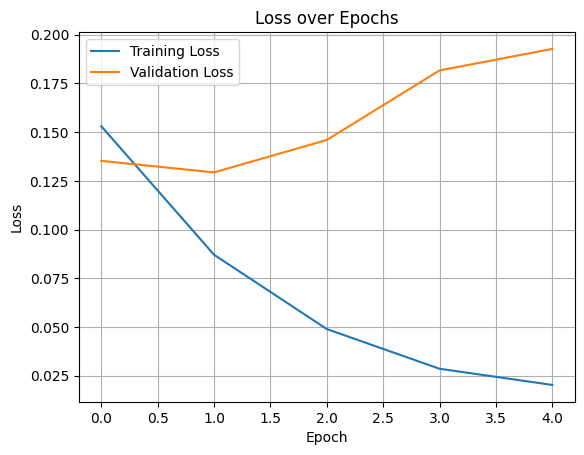

In [ ]:
# 20. Training loop

# Define paths
checkpoint_path = "checkpoints"
checkpoint_file = os.path.join(checkpoint_path, "checkpoint_epoch_5.pt")
model_save_path = os.path.join(checkpoint_path, "finetuned_bert_model")
os.makedirs(checkpoint_path, exist_ok=True)

start_training_time = time.time()

training_losses = []
validation_losses = []
best_val_loss = float("inf")
num_epochs = training_args['num_epochs']
# scaler = GradScaler()
patience = 5
early_stop_counter = 0
# best_val_loss = float("inf")

for epoch in range(training_args['num_epochs']):
# for epoch in range(start_epoch, training_args['num_epochs']):
    print(f"\n🟩 Epoch {epoch+1}/{training_args['num_epochs']}")

    # === Training Phase ===
    model.train()
    total_loss = 0
    total_train_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)

    for batch_idx, batch in enumerate(progress_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        batch_size = batch['input_ids'].size(0)
        total_train_samples += batch_size

        outputs = model(**batch)
        loss = outputs.loss

        total_loss += loss.item() * batch_size  # use batch size-weighted loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        # progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = total_loss / total_train_samples
    training_losses.append(avg_train_loss)
    print(f"✅ Training done. Avg Train Loss: {avg_train_loss:.4f}")

    # === Validation Phase ===
    model.eval()
    total_val_loss = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            batch_size = batch['input_ids'].size(0)
            total_val_samples += batch_size

            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item() * batch_size

    avg_val_loss = total_val_loss / total_val_samples
    validation_losses.append(avg_val_loss)
    print(f"✅ Validation done. Avg Val Loss: {avg_val_loss:.4f}")

    # === Save best model ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(model_save_path)
        tokenizer.save_pretrained(model_save_path)
        print(f"💾 ✅ Best model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")





    # === Save checkpoint every epoch ===
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.state_dict(),
        'training_losses': training_losses,
        'validation_losses': validation_losses
    }, os.path.join(checkpoint_path, f"checkpoint_epoch_{epoch+1}.pt"))
    print(f"📦 Checkpoint saved for epoch {epoch+1}")

total_training_time = time.time() - start_training_time
hours, rem = divmod(total_training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Total Training Time: {int(hours)}:{int(minutes):02d}:{int(seconds):02d}")

# === Save final losses to JSON ===
loss_data = {
    "training_losses": training_losses,
    "validation_losses": validation_losses,
    "training_time": f"{int(hours)}:{int(minutes):02d}:{int(seconds):02d}"
}
loss_json_path = os.path.join(checkpoint_path, "losses.json")
with open("losses.json", "w") as f:
    json.dump(loss_data, f)
print(f"📄 Losses saved to {loss_json_path}")

# === Plotting ===
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
loss_plot = os.path.join(checkpoint_path, "loss_plot.png")
plt.savefig(loss_plot.png)
plt.show()
plt.close()
print(f"📊 Loss plot saved to {loss_plot}")


In [21]:
# 21. Evaluate model
import seaborn as sns


checkpoint_path = "/content/drive/MyDrive/BertBase_sentiment_model"
# model = BertForSequenceClassification.from_pretrained(checkpoint_path, num_labels=2)
# tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
model.to(device)
model.eval()

test_dataloader = DataLoader(test_dataset, batch_size=training_args['eval_batch_size'], shuffle=False, collate_fn=data_collator)
start_time = time.time()
y_true = []
y_pred = []

model.eval()
test_dataloader = DataLoader(test_dataset, batch_size=training_args['eval_batch_size'], shuffle=False, collate_fn=data_collator)
start_time = time.time()
y_true = []
y_pred = []

for batch in test_dataloader:
    inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predictions.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
hamming = hamming_loss(y_true, y_pred)
emr = accuracy_score(y_true, y_pred)
evaluation_time = time.time() - start_time

print("✅ Evaluation Results for Fine-Tuned BERT")
print(f"Accuracy (%): {accuracy * 100:.2f}")
print(f"Precision (%): {precision * 100:.2f}")
print(f"Recall (%): {recall * 100:.2f}")
print(f"F1 Score (%): {f1 * 100:.2f}")
print(f"EMR: {emr:.2f}")
print(f"Hamming Loss (%): {hamming * 100:.2f}")
print(f"Weighted Precision (%): {precision * 100:.2f}")
print(f"Weighted Recall (%): {recall * 100:.2f}")
print(f"Weighted F1 Score (%): {f1 * 100:.2f}")
print(f"Evaluation Time: {evaluation_time:.2f} seconds")
print("\nClassification Report:\n",
classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

✅ Evaluation Results for Fine-Tuned BERT
Accuracy (%): 95.62
Precision (%): 95.52
Recall (%): 95.62
F1 Score (%): 95.54
EMR: 0.96
Hamming Loss (%): 4.38
Weighted Precision (%): 95.52
Weighted Recall (%): 95.62
Weighted F1 Score (%): 95.54
Evaluation Time: 85.29 seconds

Classification Report:
               precision    recall  f1-score   support

    Negative       0.89      0.81      0.85      1888
    Positive       0.97      0.98      0.97     10550

    accuracy                           0.96     12438
   macro avg       0.93      0.90      0.91     12438
weighted avg       0.96      0.96      0.96     12438



In [22]:
# Collect true and predicted labels
from sklearn.metrics import confusion_matrix
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
cm_plot_path = "/content/drive/MyDrive/BertBase_sentiment_model/confusion_matrix.png"
plt.savefig(cm_plot_path)
plt.close()
print(f"📊 Confusion Matrix saved to {cm_plot_path}")



📊 Confusion Matrix saved to /content/drive/MyDrive/BertBase_sentiment_model/confusion_matrix.png


In [23]:
# Regenerate losses.json and loss_plot.png from checkpoint


# Define paths
checkpoint_path = "/content/drive/MyDrive/BertBase_sentiment_model"
checkpoint_file = os.path.join(checkpoint_path, "checkpoint_epoch_5.pt")  # Use desired epoch
loss_json_path = os.path.join(checkpoint_path, "losses.json")
loss_plot_path = os.path.join(checkpoint_path, "loss_plot.png")

# Load checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(checkpoint_file, map_location=device)

# Extract losses
training_losses = checkpoint['training_losses']
validation_losses = checkpoint['validation_losses']

# Save losses to JSON
loss_data = {
    "training_losses": training_losses,
    "validation_losses": validation_losses,
    "training_time": "0:44:01"  # From your output; adjust if needed
}
with open(loss_json_path, "w") as f:
    json.dump(loss_data, f)
print(f"📄 Losses saved to {loss_json_path}")

# Plot and save loss plot
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(loss_plot_path)
plt.close()
print(f"📊 Loss plot saved to {loss_plot_path}")

📄 Losses saved to /content/drive/MyDrive/BertBase_sentiment_model/losses.json
📊 Loss plot saved to /content/drive/MyDrive/BertBase_sentiment_model/loss_plot.png


In [24]:
# 22. Predict sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=-1).item()
    id2label = {0: "negative", 1: "positive"}
    return id2label[prediction]

texts = [
    "This earphone is fantastic, great sound quality!",
    "The product is average, nothing special.",
    "Terrible experience, it broke after one use.",
    "I’m so happy with this purchase!",
    "Not worth the price, very disappointed.",
    "I love this product!",
    "It's okay, not the best.",
    "i am fine.",
    "i am not fine.",
    "i hate gpt.",
    "This was the worst purchase ever."
]
for text in texts:
    sentiment = predict_sentiment(text)
    print(f"{text} ➜ {sentiment}")

This earphone is fantastic, great sound quality! ➜ positive
The product is average, nothing special. ➜ positive
Terrible experience, it broke after one use. ➜ negative
I’m so happy with this purchase! ➜ positive
Not worth the price, very disappointed. ➜ negative
I love this product! ➜ positive
It's okay, not the best. ➜ positive
i am fine. ➜ positive
i am not fine. ➜ negative
i hate gpt. ➜ negative
This was the worst purchase ever. ➜ negative


In [25]:
# Save model
model_path = "/content/drive/MyDrive/BertBase_sentiment_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/BertBase_sentiment_model
